<a href="https://colab.research.google.com/github/benbatman/XGBoost_Projects/blob/main/COVID_XGBoost_Death_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project goal:**
Given a Covid-19 patient's current symptom, status, medical history, predict whether the patient is in high risk category or not

In [1]:
# Upload data from local machine
from google.colab import files
uploaded = files.upload()

Saving covid_data.zip to covid_data (1).zip


In [2]:
!unzip "/content/covid_data.zip"

Archive:  /content/covid_data.zip
replace Covid Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Covid Data.csv          


In [3]:
# Import dependencies 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xgboost

In [4]:
# Read in csv file 
df = pd.read_csv("/content/Covid Data.csv")
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
df_shuffled = df.sample(frac=1)
df_shuffled.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
208797,2,4,1,1,9999-99-99,97,2,39,2,2,...,2,2,2,2,2,2,2,2,6,97
951808,2,12,2,1,9999-99-99,97,2,52,97,2,...,2,2,2,2,2,2,2,2,7,97
746396,2,12,2,1,9999-99-99,97,2,37,97,2,...,2,2,2,2,2,1,2,2,7,97
549801,1,12,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,1,2,2,3,97
194489,1,4,1,1,9999-99-99,97,2,25,2,1,...,2,2,1,1,2,2,2,2,6,97


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [7]:
df_shuffled_10_percent = df.sample(frac=0.1)
df_shuffled_10_percent

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
649431,2,12,1,2,9999-99-99,2,2,60,2,2,...,2,2,1,2,2,2,2,2,3,2
940438,2,12,2,1,9999-99-99,97,2,19,97,2,...,2,2,2,2,2,2,2,2,7,97
668430,2,12,2,2,9999-99-99,2,2,69,97,2,...,2,2,2,2,2,2,2,2,5,2
564235,2,12,2,1,9999-99-99,97,2,32,97,2,...,2,2,2,2,2,2,2,1,3,97
971232,2,12,2,1,9999-99-99,97,2,86,97,2,...,2,2,2,2,2,2,2,2,7,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932542,1,12,1,1,9999-99-99,97,2,52,2,1,...,2,2,2,2,2,1,2,2,7,97
313896,2,4,2,1,9999-99-99,97,2,56,97,1,...,2,2,1,2,2,1,2,1,7,97
583302,2,12,1,1,9999-99-99,97,2,48,2,2,...,2,2,2,2,2,2,2,2,3,97
713319,1,12,2,1,9999-99-99,97,2,43,97,2,...,2,2,2,2,2,2,2,2,6,97


Will use the `DATE_DIED` column to predict if patient will die. Must transform `DATE_DIED` to binary 0 or 1 to signify death or no death

### Exploratory Data Analysis

In [12]:
df['DATE_DIED']

0          03/05/2020
1          03/06/2020
2          09/06/2020
3          12/06/2020
4          21/06/2020
              ...    
1048570    9999-99-99
1048571    9999-99-99
1048572    9999-99-99
1048573    9999-99-99
1048574    9999-99-99
Name: DATE_DIED, Length: 1048575, dtype: object

In [13]:
df['DATE_DIED'].values

array(['03/05/2020', '03/06/2020', '09/06/2020', ..., '9999-99-99',
       '9999-99-99', '9999-99-99'], dtype=object)

In [14]:
df_shuffled_10_percent['DATE_DIED'].iloc[1]

'9999-99-99'

In [15]:
#df.replace()

In [18]:
# Change dates to 0s or 1s to indicate whether patient died or did not diy
for i, _ in enumerate(df_shuffled_10_percent['DATE_DIED'].values):
  df_shuffled_10_percent['DATE_DIED'].iloc[i] = np.asscalar(np.where(df_shuffled_10_percent['DATE_DIED'].iloc[i].startswith('9999'), 0, 1))

<ipython-input-18-dcdb0d0eeb0c>:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  df_shuffled_10_percent['DATE_DIED'].iloc[i] = np.asscalar(np.where(df_shuffled_10_percent['DATE_DIED'].iloc[i].startswith('9999'), 0, 1))
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
# Check DATE_DIED datatype
type(df_shuffled_10_percent['DATE_DIED'].iloc[0])

int

In [30]:
df_shuffled_10_percent.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
649431,2,12,1,2,0,2,2,60,2,2,...,2,2,1,2,2,2,2,2,3,2
940438,2,12,2,1,0,97,2,19,97,2,...,2,2,2,2,2,2,2,2,7,97
668430,2,12,2,2,0,2,2,69,97,2,...,2,2,2,2,2,2,2,2,5,2
564235,2,12,2,1,0,97,2,32,97,2,...,2,2,2,2,2,2,2,1,3,97
971232,2,12,2,1,0,97,2,86,97,2,...,2,2,2,2,2,2,2,2,7,97


In [32]:
# Rename date_died column to "death"
df_shuffled_10_percent.rename(columns={"DATE_DIED":"Death"}, inplace=True)
df_shuffled_10_percent.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'Death', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [46]:
# Change object datatype to int datatype
df_shuffled_10_percent[['Death']] = df_shuffled_10_percent[['Death']].astype(int)

In [47]:
df_shuffled_10_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104858 entries, 649431 to 533279
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   USMER                 104858 non-null  int64
 1   MEDICAL_UNIT          104858 non-null  int64
 2   SEX                   104858 non-null  int64
 3   PATIENT_TYPE          104858 non-null  int64
 4   Death                 104858 non-null  int64
 5   INTUBED               104858 non-null  int64
 6   PNEUMONIA             104858 non-null  int64
 7   AGE                   104858 non-null  int64
 8   PREGNANT              104858 non-null  int64
 9   DIABETES              104858 non-null  int64
 10  COPD                  104858 non-null  int64
 11  ASTHMA                104858 non-null  int64
 12  INMSUPR               104858 non-null  int64
 13  HIPERTENSION          104858 non-null  int64
 14  OTHER_DISEASE         104858 non-null  int64
 15  CARDIOVASCULAR        104858 

In [53]:
# 0 is no death, 1 is death
df_shuffled_10_percent['Death'].value_counts()

0    97110
1     7748
Name: Death, dtype: int64

In [58]:
print(f"{(df_shuffled_10_percent['Death'].value_counts()[0] /  df_shuffled_10_percent['Death'].value_counts().sum()) * 100:.2f}% of our target variable belongs to one outcome. The 'no death' category\nClasses are imbalanced")

92.61% of our target variable belongs to one outcome. The 'no death' category
Classes are imbalanced


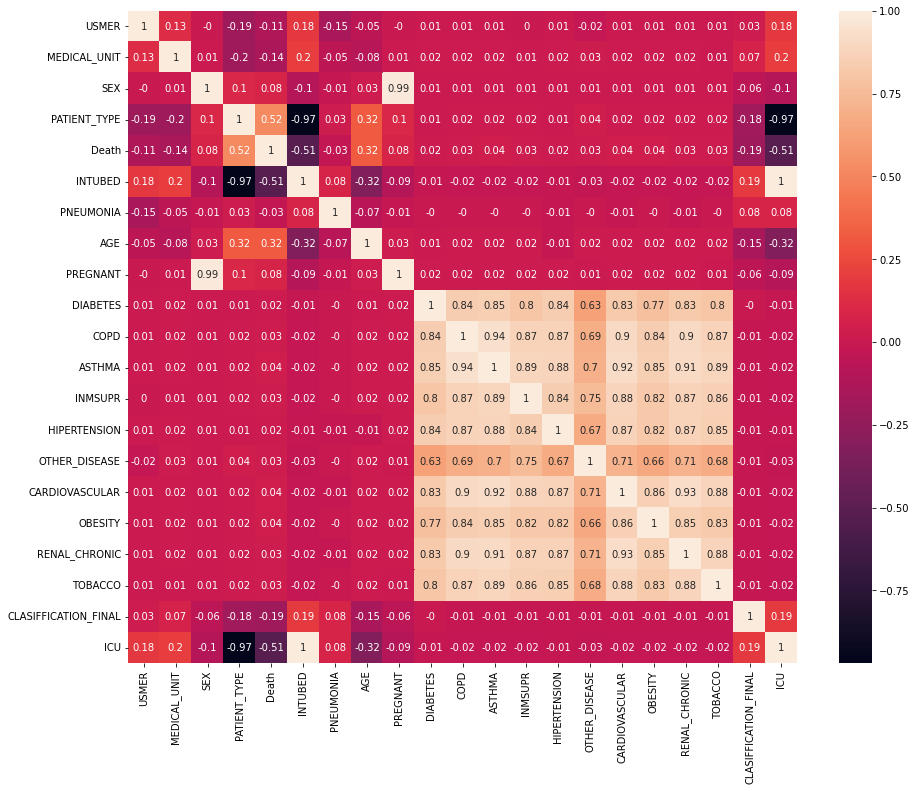

In [48]:
# Build a correlation matrix to view features of most importance or multicollinearity
import seaborn as sns
plt.figure(figsize=(15,12))
corr_matrix = df_shuffled_10_percent.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

The following predictor variables will be used to begin with: 
- Age
- Patient_type (hospitalized or not)


In [62]:
# Change patient_type to 0s and 1s
df_shuffled_10_percent['PATIENT_TYPE'].replace([2], 0, inplace=True)

In [64]:
# Values as 97 in INTUBED column are missing values
# Most of the intubed values are missing...
df_shuffled_10_percent['INTUBED'].value_counts()

97    84892
2     15814
1      3367
99      785
Name: INTUBED, dtype: int64

In [65]:
# Create features and target variables from df_shuffled_10_percent dataframe
X = df_shuffled_10_percent[['AGE', 'PATIENT_TYPE']]
y = df_shuffled_10_percent['Death']

X[:10]

,AGE,PATIENT_TYPE
649431,60,0
940438,19,1
668430,69,0
564235,32,1
971232,86,1
673626,39,1
425335,89,0
848239,36,1
264049,42,1
241444,84,1


In [66]:
y[:10]

649431    0
940438    0
668430    0
564235    0
971232    0
673626    0
425335    0
848239    0
264049    0
241444    0
Name: Death, dtype: int64

In [68]:
# Split into train/test splits
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=7)
len(X_train), len(X_test), len(y_train), len(y_test)

(83886, 20972, 83886, 20972)

In [70]:
# Create XGBoost matrices
train_matrix = xgboost.DMatrix(X_train, y_train)
test_matrix = xgboost.DMatrix(X_test, y_test)
train_matrix, test_matrix

(<xgboost.core.DMatrix at 0x7fba3bf0c820>,
 <xgboost.core.DMatrix at 0x7fba3bf0ce80>)

In [72]:
# Set the parameters
parameters_0 = {
    'learning_rate': 0.3, 
    'max_depth': 2, 
    'colsample_bytree': 1, 
    'subsample': 1, 
    'min_child_weight': 1, 
    'gamma': 0,
    'random_state': 7, 
    'eval_metric': 'auc', 
    'objective': "binary:logistic"
}

In [73]:
# Run XGBoost model_0
model_0 = xgboost.train(params=parameters_0, 
                        dtrain=train_matrix, 
                        num_boost_round=200, 
                        evals=[(test_matrix, "yes")], 
                        verbose_eval=50)

[0]	yes-auc:0.916368
[50]	yes-auc:0.937702
[100]	yes-auc:0.937717
[150]	yes-auc:0.937655
[199]	yes-auc:0.937623


In [74]:
# Evaluate model
model_0.eval(test_matrix)

'[0]\teval-auc:0.937623'

In [75]:
# Make predictions on test data 
y_preds = model_0.predict(data=test_matrix)
y_preds

array([0.21661647, 0.00186677, 0.24238703, ..., 0.52481794, 0.0020261 ,
       0.01948401], dtype=float32)

In [76]:
y_preds.shape, y_preds.max(), y_preds.min()

((20972,), 0.7509612, 0.00016257263)

In [81]:
y_preds = np.round(y_preds)
y_preds

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [82]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm_0 = confusion_matrix(y_true=y_test, 
                      y_pred=y_preds) 
cm_0

array([[18939,   483],
       [ 1006,   544]])

In [83]:
# Classification report on model_0
report_0 = classification_report(y_true=y_test, 
                                y_pred=y_preds)
print(report_0)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     19422
           1       0.53      0.35      0.42      1550

    accuracy                           0.93     20972
   macro avg       0.74      0.66      0.69     20972
weighted avg       0.92      0.93      0.92     20972



In [103]:
# Make more predictions on test data 
y_preds = model_0.predict(data=test_matrix)
y_preds

array([0.21661647, 0.00186677, 0.24238703, ..., 0.52481794, 0.0020261 ,
       0.01948401], dtype=float32)

In [104]:
# Change threshold of rounding
y_preds = np.where(y_preds > .4, 1, 0)
y_preds

array([0, 0, 0, ..., 1, 0, 0])

In [105]:
cm_0_1 = confusion_matrix(y_true=y_test, 
                      y_pred=y_preds) 
cm_0_1

array([[18380,  1042],
       [  569,   981]])

In [108]:
len(y_test)

20972

In [107]:
np.sum(y_test == y_preds)

19361

In [122]:
# Create accuracy function 
def accuracy_score(y_true, y_pred): 
  correct_pred = np.sum(y_test == y_pred)
  acc = (correct_pred / len(y_pred)) * 100
  print("Accuracy score\n-------------")
  return acc.round(2)

In [123]:
accuracy_score(y_true=y_test,
               y_pred=y_preds)

Accuracy score
-------------


92.32

In [106]:
# Classification report on model_0
report_0_1 = classification_report(y_true=y_test, 
                                y_pred=y_preds)
print(report_0_1)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19422
           1       0.48      0.63      0.55      1550

    accuracy                           0.92     20972
   macro avg       0.73      0.79      0.75     20972
weighted avg       0.93      0.92      0.93     20972



Using Age and hospitalization as predictor variables our model has an accuracy around ~92-93%. Tried adjusting the treshold to reduce the number of false negatives but that in turn increased the number of false positives.

### Fine-tuning Hyperparameters



